[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/DecisionTree.ipynb)

# Decision tree 
We want implement a decision tree for classification from scratch. For this, first we define a data-structure to represent nodes, then we define a function to pick the best *test* for a node based on a *cost function*. Starting from the root node, we use this test function recursively to find the best split until a *max-depth* is reached. Procedures closely follow our presentation in the class. This implementation is rather involved. You may find it  more difficult to follow compared to KNN implementation. 

##Initialization

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

import pandas as pd
import copy
pd.set_option('max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BCW_prepro = pd.read_csv('drive//My Drive/breast_cancer_wisconsin.csv') 

#Split into train and test
num_instances_preprocessing = BCW_prepro.shape[0]

test_prop = 0.15
n_test = int(test_prop*num_instances_preprocessing) 
inds = np.random.permutation(num_instances_preprocessing)
BCW_prepro_TEST = BCW_prepro.loc[inds[:n_test]]
BCW_prepro_TRAINING = BCW_prepro.loc[inds[n_test:]]

In [ ]:
#BCW_prepro.shape[0]
np.savetxt("index_test.csv", inds[:n_test], delimiter=",")
BCW_prepro_TEST.to_csv('BCW_prepro_TEST.csv')
BCW_prepro_TRAINING.to_csv('BCW_prepro_TRAINING.csv')
#jokes=pd.read_csv('drive//My Drive/jokes_processed_20201110.csv', index_col=0, 

In [ ]:
type(inds)

numpy.ndarray

In [ ]:
BCW = pd.read_csv('drive//My Drive/breast_cancer_wisconsin.csv') 
BCW_TEST = pd.read_csv('drive//My Drive/BCW_prepro_TEST.csv', index_col=0)
BCW_TRAINING = pd.read_csv('drive//My Drive/BCW_prepro_TRAINING.csv', index_col=0)

In [ ]:
BCW_TEST

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
629,1218982,4,1,1,1,2,1,1,1,1,2
259,242970,5,7,7,1,5,8,3,4,1,2
108,1171710,1,1,1,1,2,1,2,3,1,2
142,1183983,9,5,5,4,4,5,4,3,3,4
664,1345593,3,1,1,3,2,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
402,1223003,5,3,3,1,2,1,2,1,1,2
586,1254538,8,10,10,10,6,10,10,10,1,4
406,1231853,4,2,2,1,2,1,2,1,1,2
127,1177027,3,1,1,1,2,1,3,1,1,2


In [ ]:
BCW = pd.read_csv('drive//My Drive/breast_cancer_wisconsin.csv') 
BCW_TEST = pd.read_csv('drive//My Drive/BCW_prepro_TEST.csv', index_col=0)
BCW_TRAINING = pd.read_csv('drive//My Drive/BCW_prepro_TRAINING.csv', index_col=0)

cleanup_target = {"Class":     {2: 0, 4: 1} }
BCW = BCW.replace(cleanup_target)
BCW_TEST = BCW_TEST.replace(cleanup_target)
BCW_TRAINING = BCW_TRAINING.replace(cleanup_target)

In [ ]:
BCW_TRAINING.head()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
352,846832,3,4,5,3,7,3,4,6,1,0
646,1311033,1,2,2,1,2,1,1,1,1,0
347,831268,1,1,1,1,1,1,1,3,1,0
203,1217051,5,1,1,1,2,1,3,1,1,0
288,543558,6,1,3,1,4,5,5,10,1,1


In [ ]:
BCW.describe()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [ ]:
BCW[BCW.eq('?').any(1)].groupby('Class').count()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
Class,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14
1,2,2,2,2,2,2,2,2,2,2


In [ ]:
BCW[~BCW.eq('?').any(1)].groupby('Class').count()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
Class,,,,,,,,,,
0,444,444,444,444,444,444,444,444,444,444
1,239,239,239,239,239,239,239,239,239,239


In [ ]:
BCW[BCW.eq('?').any(1)]

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
23,1057013,8,4,5,1,2,?,7,3,1,1
40,1096800,6,6,6,9,6,?,7,8,1,0
139,1183246,1,1,1,1,1,?,2,1,1,0
145,1184840,1,1,3,1,2,?,2,1,1,0
158,1193683,1,1,2,1,3,?,1,1,1,0
164,1197510,5,1,1,1,2,?,3,1,1,0
235,1241232,3,1,4,1,2,?,3,1,1,0
249,169356,3,1,1,1,2,?,3,1,1,0
275,432809,3,1,3,1,2,?,2,1,1,0
292,563649,8,8,8,1,2,?,6,10,1,1


In [ ]:
#print('Counts by class: ', BCW['Class'].value_counts() )
nb_class_0, nb_class_1 = BCW['Class'].value_counts().iloc[0], BCW['Class'].value_counts().iloc[1]
percent_class0, percent_class1 = BCW['Class'].value_counts(normalize=True).iloc[0]*100, BCW['Class'].value_counts(normalize=True).iloc[1]*100
print(f'Nb Class 0 = {nb_class_0} [{percent_class0:.2f}%] \nNb Class 1 = {nb_class_1} [{percent_class1:.2f}%]')


Nb Class 0 = 458 [65.52%] 
Nb Class 1 = 241 [34.48%]


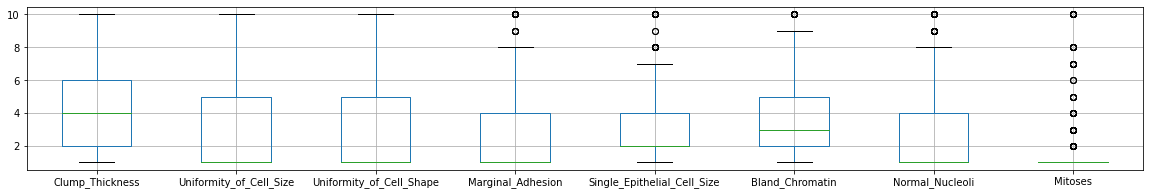

In [ ]:
%matplotlib inline

datachart = BCW.drop(['Class','id'],axis=1)
#datachart['Bare Nuclei'] = pd.to_numeric(datachart['Bare_Nuclei'])
datachart.boxplot(figsize=(20,3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f613d2501d0>,
      dtype=object)

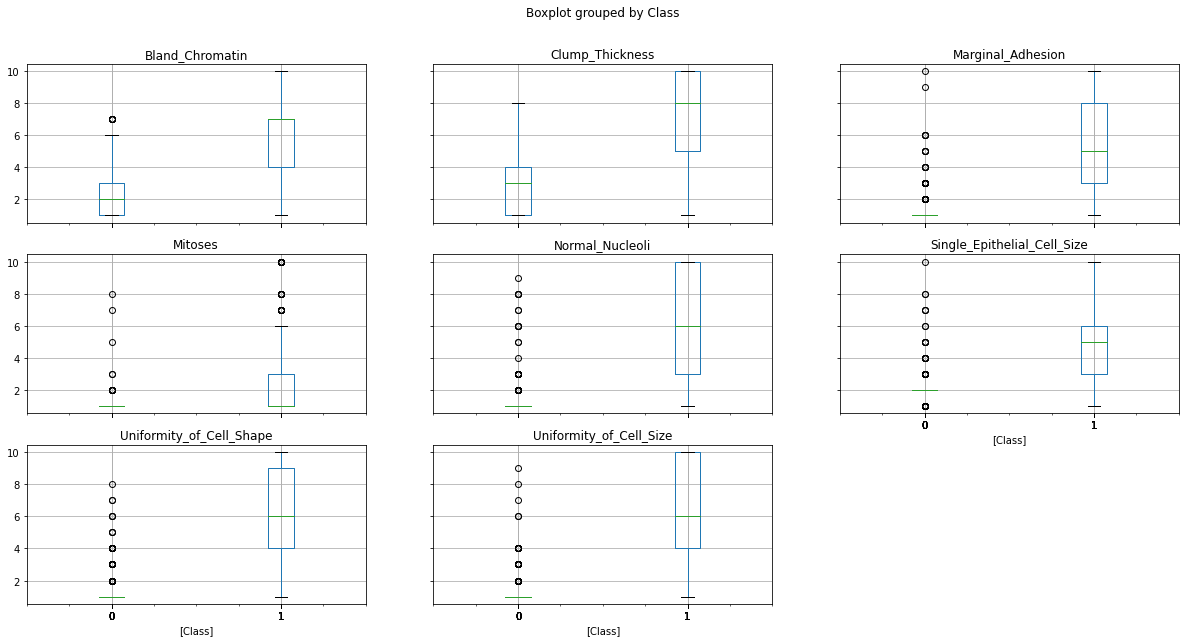

In [ ]:
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
datachart1 = BCW.drop(['id'],axis=1)
datachart1.boxplot(by='Class', figsize=(20,10))

In [ ]:
corrMatrix = BCW.drop(['id'],axis=1)[~BCW.eq('?').any(1)].corr()
corrMatrix

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
Clump_Thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.553742,0.534066,0.350957,0.714790
Uniformity_of_Cell_Size,0.642481,1.000000,0.907228,0.706977,0.753544,0.755559,0.719346,0.460755,0.820801
Uniformity_of_Cell_Shape,0.653470,0.907228,1.000000,0.685948,0.722462,0.735344,0.717963,0.441258,0.821891
Marginal_Adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.668567,0.603121,0.418898,0.706294
Single_Epithelial_Cell_Size,0.523596,0.753544,0.722462,0.594548,1.000000,0.618128,0.628926,0.480583,0.690958
Bland_Chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,1.000000,0.665602,0.346011,0.758228
Normal_Nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.665602,1.000000,0.433757,0.718677
Mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.346011,0.433757,1.000000,0.423448
Class,0.714790,0.820801,0.821891,0.706294,0.690958,0.758228,0.718677,0.423448,1.000000


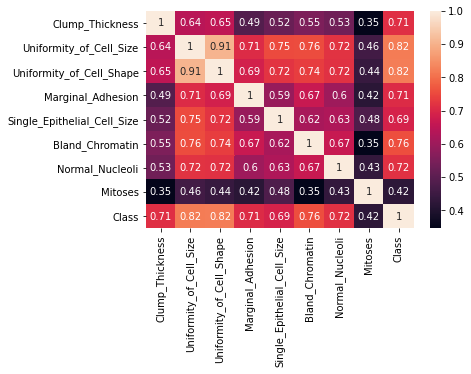

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
#BCW['Clump_Thickness'].hist(by=BCW['Class'], bins=10)
BCW.groupby('Class')['Clump_Thickness'].value_counts(sort=False)

Class  Clump_Thickness
0      1                  142
       2                   46
       3                   96
       4                   68
       5                   85
       6                   16
       7                    1
       8                    4
1      1                    3
       2                    4
       3                   12
       4                   12
       5                   45
       6                   18
       7                   22
       8                   42
       9                   14
       10                  69
Name: Clump_Thickness, dtype: int64

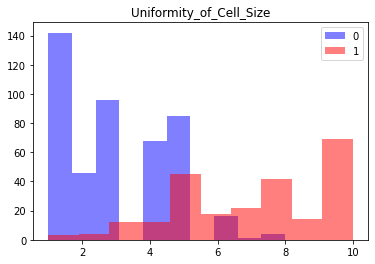

In [ ]:
plt.hist(BCW[BCW['Class']==0]['Clump_Thickness'], bins=10, alpha=0.5, label='0', color='b')
plt.hist(BCW[BCW['Class']==1]['Clump_Thickness'], bins=10, alpha=0.5, label='1', color='r')
plt.legend(loc='upper right')
plt.title('Uniformity_of_Cell_Size')
plt.savefig('sample.png')

1 Clump_Thickness
2 Uniformity_of_Cell_Size
3 Uniformity_of_Cell_Shape
4 Marginal_Adhesion
5 Single_Epithelial_Cell_Size
6 Bare_Nuclei
7 Bland_Chromatin
8 Normal_Nucleoli
9 Mitoses
10 Class


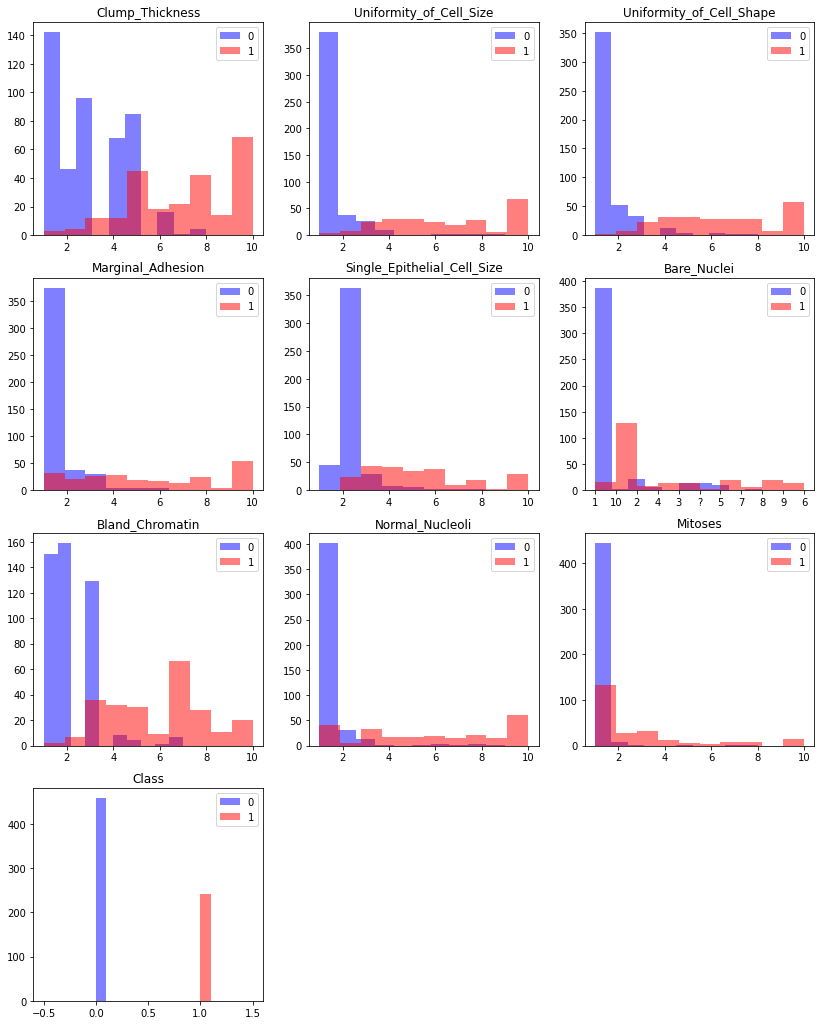

In [ ]:
plt.rcParams["figure.figsize"] = [14,18]
for num, col in enumerate(BCW.columns):
    if col == 'id':
      continue
    print(num, col)
    plt.subplot(4,3, num)
    plt.hist(BCW[BCW['Class']==0][col], bins=10, alpha=0.5, label='0', color='b')
    plt.hist(BCW[BCW['Class']==1][col], bins=10, alpha=0.5, label='1', color='r')
    plt.legend(loc='upper right')
    plt.title(col)

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Data structure
We use a binary tree to assign information to the nodes of the decision tree. In particular, the instances associated with that node (`data_indices`) and the test that is used to further split that node, in the case non-leaf nodes (`split_feature, split_value`). Here, we assume each test involves a single feature, and all features are real-valued.

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

## Greedy spliting of a node
Given a node, we consider all possible feature-value combinations for splitting the data. One such **test** that produces the lowest cost according to a supplied cost function (`cost_fn`) is returned.

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th f  eature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

## Cost functions

Below we implement two cost functions corresponding to misclassification rate and entropy.

In [ ]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes SUM weighted entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes MAX weighted entropy of the labels by computing the class probabilities
def cost_entropy_wmax(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return np.max(-class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes SUM weighted the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

#computes MAX weighted the gini index cost
def cost_gini_index_wmax(labels):
    class_probs = np.bincount(labels) / len(labels)
    return np.max(class_probs * (1-class_probs))       #expression for gini index 1-\sigma p(x)^2

we are now ready to implement the classifier:

when to stop splitting?
1. if there are not enough points under the current node (`min_leaf_instances`)
2. if reached maximum depth (`max_depth`)
3. if the decrease in the cost is negligible (not implemented)
Below is the template for the class, next we implement `fit` and `predict` methods.

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass
    
    def evaluate_acc(self, y_truth, y_pred):
        pass

## Fit
To fit the tree to the data, we call the `_fit_tree` method on the `root_node` of the tree. In this method the _best_ test (split) for the current node is found, and the method is recursively called on the left and right child. If the `max_depth` is reached or the number of instances under the current node is below `min_leaf_instances` the node is not split anymore, resulting in a leaf node.

In [ ]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

def evaluate_acc(self, y_truth, y_pred):
    accuracy = np.sum(y_pred == y_truth)/y_truth.shape[0]
    return accuracy

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree
DecisionTree.evaluate_acc = evaluate_acc

## New predictions
Given a new instance, starting from the `root` of the `DecisionTree` we check to see if the instance falls in the left or right split, and repeat the process with left or right node depending on the test, until we reach a leaf node. The class probabilities of the training data under the leaf is returned.

In [ ]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            #print('node split feature: ' , node.split_feature)
            #print('node split value: ' , node.split_value)
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# Experiments
For more information on visualizing the model's performace on the data and its decision boundry go through the experiment section of the KNN code or watch the coding tutorial on KNN. 
We conveniently load the dataset from the sklearn collection of datasets

##Preparation Extra Features FOR BCW

In [ ]:
BCW_TRAIN_DT = copy.copy(BCW_TRAINING.drop(['id'],axis=1)[~BCW_TRAINING.eq('?').any(1)])
BCW_TRAIN_DT = BCW_TRAIN_DT.astype(np.int) 
BCW_TRAIN_DT['ClumpXBland'] = BCW_TRAIN_DT['Clump_Thickness']*BCW_TRAIN_DT['Bland_Chromatin']
BCW_TRAIN_DT['NNXMito'] = BCW_TRAIN_DT['Normal_Nucleoli']*BCW_TRAIN_DT['Mitoses']
BCW_TRAIN_DT['SUM'] = BCW_TRAIN_DT['Clump_Thickness']+BCW_TRAIN_DT['Uniformity_of_Cell_Shape']+BCW_TRAIN_DT['Marginal_Adhesion']+BCW_TRAIN_DT['Single_Epithelial_Cell_Size']+BCW_TRAIN_DT['Bare_Nuclei']

In [ ]:
BCW_TEST_DT = copy.copy(BCW_TEST.drop(['id'],axis=1)[~BCW_TEST.eq('?').any(1)])
BCW_TEST_DT = BCW_TEST_DT.astype(np.int) 
BCW_TEST_DT['ClumpXBland'] = BCW_TEST_DT['Clump_Thickness']*BCW_TEST_DT['Bland_Chromatin']
BCW_TEST_DT['NNXMito'] = BCW_TEST_DT['Normal_Nucleoli']*BCW_TEST_DT['Mitoses']
BCW_TEST_DT['SUM'] = BCW_TEST_DT['Clump_Thickness']+BCW_TEST_DT['Uniformity_of_Cell_Shape']+BCW_TEST_DT['Marginal_Adhesion']+BCW_TEST_DT['Single_Epithelial_Cell_Size']+BCW_TEST_DT['Bare_Nuclei']

In [ ]:
x_train, y_train  = BCW_TRAIN_DT.loc[:, BCW_TRAIN_DT.columns != 'Class'].to_numpy(), BCW_TRAIN_DT['Class'].to_numpy()
x_test, y_test = BCW_TEST_DT.loc[:, BCW_TEST_DT.columns != 'Class'].to_numpy(), BCW_TEST_DT['Class'].to_numpy()

In [ ]:
#define a function for the MSE loss
loss1 = lambda y, yh: np.mean((y-yh)**2)
#define a function for the Misclass loss
loss = lambda y, yh: np.mean(y==yh)

## Cross Validation for Decision Tree

next we fit the tree to the training data and predict on the test data. 

accuracy is 94.9.


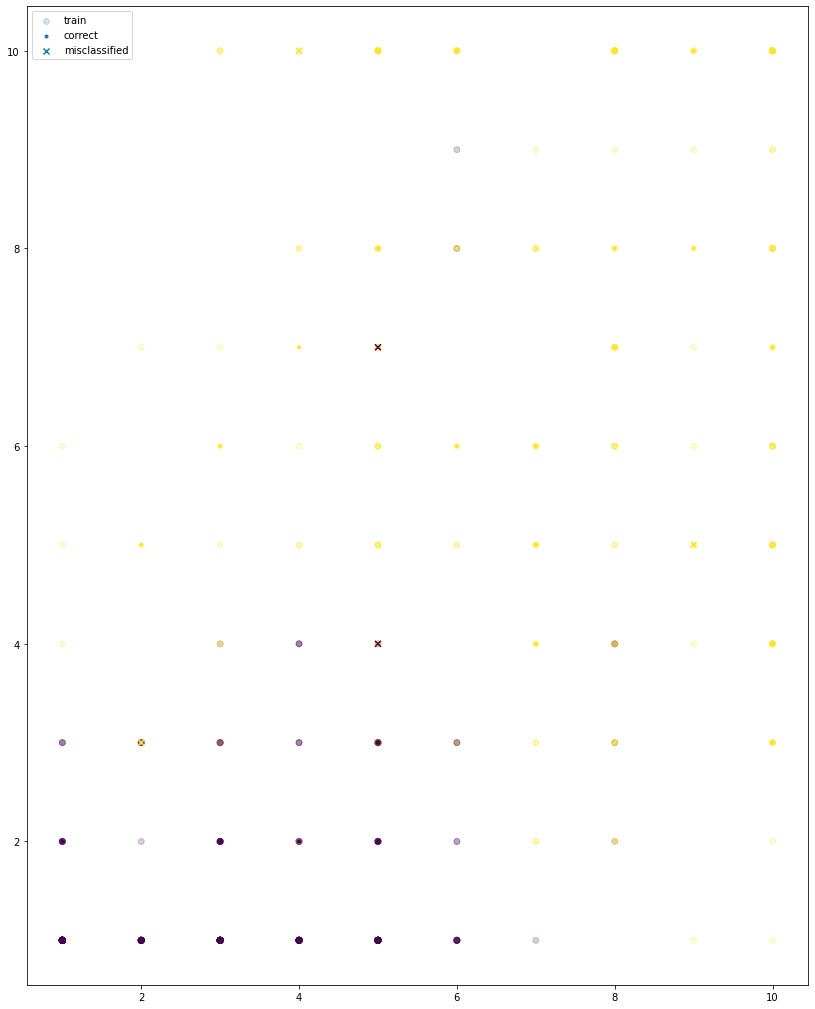

In [ ]:
tree = DecisionTree(max_depth=4, cost_fn=cost_entropy, min_leaf_instances=1)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

We then plot the *decision boundary*

In [ ]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(), x1.ravel())).T

model = DecisionTree(max_depth=200)
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
print(y_train)
print(y_train.shape)
print(y_train_prob.shape)
print(y_train_prob[0:10])
print(x_train.shape)
y_prob_all = model.fit(x_train, y_train).predict(x_all)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

In [ ]:
# Clump_Thickness 1
# Uniformity_of_Cell_Size 2
# Bland_Chromatin 6

BCW = BCW[~BCW.eq('?').any(1)]
BCW = BCW.astype(np.int)

num_classes = np.max(BCW['Class']) + 1

x0v = np.linspace(np.min(BCW['Clump_Thickness']), np.max(BCW['Clump_Thickness']), 200)
x1v = np.linspace(np.min(BCW['Bland_Chromatin']), np.max(BCW['Bland_Chromatin']), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for depth in [4, 20]:
  model = DecisionTree(num_classes=None, max_depth=depth, cost_fn=cost_misclassification, min_leaf_instances=1)

  y_train_prob = np.zeros((y_train.shape[0], num_classes))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all = model.fit(x_train[:,[1,6]], y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(x_train[:,1], x_train[:,6], c=y_train_prob[:,0], marker='o', alpha=0.5)
  ax.scatter(x_all[:,0], x_all[:,1], c=y_pred_all[:,0], marker='.', alpha=0.01)
  ax.set_ylabel('Bland_Chromatin', fontsize=15)
  ax.set_xlabel('Clump_Thickness', fontsize=15)
  ax.set_title(f"Decision Tree (max_depth={depth})", fontsize=18)
  #ax.legend()
  plt.show()

In [ ]:
def cross_validation(x_train, y_train, num_fold, cost_fn, depth_choices, leaf_instance_choices):
    
  size_validation_set = x_train.shape[0] // num_fold
  print("Cross validation N-fold: ", num_fold, " ,size validation set: ", size_validation_set)
  #print("Using", cost_fn.__name__, "as cost function:")
  ##from collections import defaultdict
  ##results_experiment = defaultdict(dict)
  results_experiment = {}
  for c, cost_fn in enumerate(cost_fn):
    print("Using", cost_fn.__name__, "as cost function:")
    print("minimum_number_per_leaf, max_depth, mean_accuracy, mean_classification_rate")    
    for num_in_leaf in leaf_instance_choices:
        for depth in depth_choices:
             
            tree = DecisionTree(num_classes=None, max_depth=depth, cost_fn=cost_fn, min_leaf_instances=num_in_leaf)
            
            accuracy_list = []
            miss_class_list = []
        
            for i in range(num_fold):
                feature_part_1, label_part_1 = x_train[:i*size_validation_set, :], y_train[:i*size_validation_set]
                x_vali, y_vali = x_train[i*size_validation_set:(i+1)*size_validation_set, :], y_train[i*size_validation_set:(i+1)*size_validation_set]
                feature_part_2, label_part_2 = x_train[(i+1)*size_validation_set:, :], y_train[(i+1)*size_validation_set:]
                feature = np.concatenate((feature_part_1, feature_part_2), axis=0)
                label = np.concatenate((label_part_1, label_part_2), axis=0)
                
                probs_test = tree.fit(feature, label).predict(x_vali)
                y_pred = np.argmax(probs_test,1)
                miss_classif = np.sum(y_pred != y_vali)/y_vali.shape[0]
                accuracy = tree.evaluate_acc(y_vali, y_pred) 
                #accuracy = np.sum(y_pred == y_vali)/y_vali.shape[0]
                
                #print(num_in_leaf, depth, i, accuracy)
                
                accuracy_list.append(accuracy)
                miss_class_list.append(miss_classif)
            
            mean_accuracy = sum(accuracy_list) / len(accuracy_list)
            mean_miss_class = sum(miss_class_list) / len(miss_class_list)
            print(f'{num_in_leaf},  {depth},  {mean_accuracy*100:.1f}, {mean_miss_class*100:.1f}')
            #results_experiment[cost_fn.__name__] = {}
            #results_experiment[cost_fn.__name__][num_in_leaf] = {}
            #results_experiment[num_in_leaf][depth] = 
            results_experiment[cost_fn.__name__ + ' ' + str(num_in_leaf) + ' ' + str(depth)]= 100*round(mean_accuracy,4)
  return results_experiment

In [ ]:

#cost_misclassification
#cost_entropy
#cost_gini_index
#cost_entropy_wmax
#cost_gini_index_wmax

#cost_function = cost_misclassification
depth_choices = [2, 3, 4, 5, 6, 8, 10, 15, 20, 50, 100, 200]
#depth_choices = [6, 8]
leaf_instance_choices = [1, 2, 5, 10, 15, 20, 25, 50]
#leaf_instance_choices = [1]
num_fold = 5

cost_list = [cost_misclassification, cost_entropy, cost_gini_index,cost_entropy_wmax,cost_gini_index_wmax]
#cost_list = [cost_entropy]
results = cross_validation(x_train, y_train, num_fold, cost_list, depth_choices, leaf_instance_choices)

In [ ]:
#type(results)
pd.DataFrame(results.items())

## RUNNING DECISION TREE FOR HEPATITIS DATASET

In [ ]:
pd.DataFrame(results.items()).to_excel("outputBCW_EXTRAfeatures20200203.xlsx")  

In [ ]:
HEP_prepro = pd.read_csv('drive//My Drive/hepatitis.csv') 

#Split into train and test
num_instances_preprocessing_HEP = HEP_prepro.shape[0]

test_prop = 0.15
n_test = int(test_prop*num_instances_preprocessing_HEP) 
inds = np.random.permutation(num_instances_preprocessing_HEP)
HEP_prepro_TEST = HEP_prepro.loc[inds[:n_test]]
HEP_prepro_TRAINING = HEP_prepro.loc[inds[n_test:]]

In [ ]:
#BCW_prepro.shape[0]
np.savetxt("index_test_hep.csv", inds[:n_test], delimiter=",")
HEP_prepro_TEST.to_csv('HEP_prepro_TEST.csv')
HEP_prepro_TRAINING.to_csv('HEP_prepro_TRAINING.csv')


In [ ]:
HEP = pd.read_csv('drive//My Drive/hepatitis.csv') 
HEP_TEST = pd.read_csv('drive//My Drive/HEP_prepro_TEST.csv', index_col=0)
HEP_TRAINING = pd.read_csv('drive//My Drive/HEP_prepro_TRAINING.csv', index_col=0)

In [ ]:

HEP[HEP.eq('?').any(1)].groupby('Class').count()

In [ ]:
#print('Counts by class: ', BCW['Class'].value_counts() )
nb_class_0, nb_class_1 = HEP['Class'].value_counts().iloc[0], HEP['Class'].value_counts().iloc[1]
percent_class0, percent_class1 = HEP['Class'].value_counts(normalize=True).iloc[0]*100, HEP['Class'].value_counts(normalize=True).iloc[1]*100
print(f'Nb Class 2 = {nb_class_0} [{percent_class0:.2f}%] \nNb Class 1 = {nb_class_1} [{percent_class1:.2f}%]')

In [ ]:
HEP['Class'].value_counts()

In [ ]:
HEP.mask(HEP.eq('?')).dropna()

In [ ]:
HEP = HEP.mask(HEP.eq('?')).dropna() #removes all "?"
for i in range(20): #converts string columns to float
  HEP.iloc[:,i] = pd.to_numeric(HEP.iloc[:,i]) 
#HEP = (HEP-HEP.min())/(HEP.max()-HEP.min()) #this normalizes all the data (categorical and continuous) to fit in the range [0,1]
HEP.iloc[:,0] = HEP.iloc[:,0].astype(int) #converts the y column to int so that bincount works
#HEP = HEP.to_numpy()
HEP['BILIRUBIN'] = (HEP['BILIRUBIN']*10).astype(int)
HEP['ALBUMIN'] = (HEP['ALBUMIN']*10).astype(int)


HEP_TEST = HEP_TEST.mask(HEP_TEST.eq('?')).dropna() #removes all "?"
for i in range(20): #converts string columns to float
  HEP_TEST.iloc[:,i] = pd.to_numeric(HEP_TEST.iloc[:,i]) 
#HEP = (HEP-HEP.min())/(HEP.max()-HEP.min()) #this normalizes all the data (categorical and continuous) to fit in the range [0,1]
HEP_TEST.iloc[:,0] = HEP_TEST.iloc[:,0].astype(int) #converts the y column to int so that bincount works
#HEP = HEP.to_numpy()
HEP_TEST['BILIRUBIN'] = (HEP_TEST['BILIRUBIN']*10).astype(int)
HEP_TEST['ALBUMIN'] = (HEP_TEST['ALBUMIN']*10).astype(int)


HEP_TRAINING = HEP_TRAINING.mask(HEP_TRAINING.eq('?')).dropna() #removes all "?"
for i in range(20): #converts string columns to float
  HEP_TRAINING.iloc[:,i] = pd.to_numeric(HEP_TRAINING.iloc[:,i]) 
#HEP = (HEP-HEP.min())/(HEP.max()-HEP.min()) #this normalizes all the data (categorical and continuous) to fit in the range [0,1]
HEP_TRAINING.iloc[:,0] = HEP_TRAINING.iloc[:,0].astype(int) #converts the y column to int so that bincount works
#HEP = HEP.to_numpy()
HEP_TRAINING['BILIRUBIN'] = (HEP_TRAINING['BILIRUBIN']*10).astype(int)
HEP_TRAINING['ALBUMIN'] = (HEP_TRAINING['ALBUMIN']*10).astype(int)

In [ ]:
cleanup_target = {"Class":     {1: 0, 2: 1}, "SEX": {1: 0, 2: 1}, "STEROID": {1: 0, 2: 1}, "ANTIVIRALS": {1: 0, 2: 1}, "FATIGUE": {1: 0, 2: 1} 
                  , "MALAISE": {1: 0, 2: 1}, "ANOREXIA": {1: 0, 2: 1}, "LIVER_BIG": {1: 0, 2: 1}, "LIVER_FIRM": {1: 0, 2: 1}, "SPLEEN_PALPABLE": {1: 0, 2: 1}
                  , "SPIDERS": {1: 0, 2: 1}, "ASCITES": {1: 0, 2: 1}, "VARICES": {1: 0, 2: 1}}
HEP = HEP.replace(cleanup_target)
HEP_TEST = HEP_TEST.replace(cleanup_target)
HEP_TRAINING = HEP_TRAINING.replace(cleanup_target)


In [ ]:
HEP_TEST

In [ ]:
corrMatrixHP = HEP.drop(['Class'],axis=1)[~HEP.eq('?').any(1)].corr()
corrMatrixHP

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
sn.heatmap(corrMatrixHP, annot=True,linewidths=.5, ax=ax)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [14,18]
for num, col in enumerate(HEP.columns):
    if col == 'Class':
      continue
    print(num, col)
    plt.subplot(5,4, num)
    plt.hist(HEP[HEP['Class']==0][col], bins=10, alpha=0.5, label='0', color='b')
    plt.hist(HEP[HEP['Class']==1][col], bins=10, alpha=0.5, label='1', color='r')
    plt.legend(loc='upper right')
    plt.title(col)


In [ ]:
#HEP['HISTCXSGOT'] = HEP['HISTOLOGY']*HEP['SGOT']
#HEP['ALBXPROT'] = HEP['ALBUMIN']*HEP['PROTIME']
#HEP['SUM'] = HEP['STEROID']+HEP['ANTIVIRALS']+(1-HEP['FATIGUE'])+ HEP['MALAISE'] + HEP['ANOREXIA'] + HEP['LIVER_BIG'] + HEP['LIVER_FIRM'] + HEP['SPLEEN_PALPABLE'] + HEP['SPIDERS'] + HEP['ASCITES'] + HEP['VARICES']

HEP_TEST['HISTCXSGOT'] = HEP_TEST['HISTOLOGY']*HEP_TEST['SGOT']
HEP_TEST['ALBXPROT'] = HEP_TEST['ALBUMIN']*HEP_TEST['PROTIME']
HEP_TEST['SUM'] = HEP_TEST['STEROID']+HEP_TEST['ANTIVIRALS']+(HEP_TEST['FATIGUE'])+ HEP_TEST['MALAISE'] + HEP_TEST['ANOREXIA'] + HEP_TEST['LIVER_BIG'] + HEP_TEST['LIVER_FIRM'] + HEP_TEST['SPLEEN_PALPABLE'] + HEP_TEST['SPIDERS'] + HEP_TEST['ASCITES'] + HEP_TEST['VARICES']

HEP_TRAINING['HISTCXSGOT'] = HEP_TRAINING['HISTOLOGY']*HEP_TRAINING['SGOT']
HEP_TRAINING['ALBXPROT'] = HEP_TRAINING['ALBUMIN']*HEP_TRAINING['PROTIME']
HEP_TRAINING['SUM'] = HEP_TRAINING['STEROID']+HEP_TRAINING['ANTIVIRALS']+(HEP_TRAINING['FATIGUE'])+ HEP_TRAINING['MALAISE'] + HEP_TRAINING['ANOREXIA'] + HEP_TRAINING['LIVER_BIG'] + HEP_TRAINING['LIVER_FIRM'] + HEP_TRAINING['SPLEEN_PALPABLE'] + HEP_TRAINING['SPIDERS'] + HEP_TRAINING['ASCITES'] + HEP_TRAINING['VARICES']



In [ ]:
#THIS IS FOR THE HEPATITIS DATASET
x_train2, y_train2 = HEP_TRAINING.iloc[:,1:].to_numpy(), HEP_TRAINING.iloc[:,0].to_numpy() #takes first column for y and all the other columns for x
x_test2, y_test2 = HEP_TEST.iloc[:,1:].to_numpy(), HEP_TEST.iloc[:,0].to_numpy() 



In [ ]:
x_test2.shape

In [ ]:
#cost_misclassification
#cost_entropy
#cost_gini_index

#cost_function = cost_misclassification
depth_choices = [1,2,3,4, 5, 6, 8, 10, 15, 20]

#depth_choices = [4]
leaf_instance_choices = [1, 2, 5, 10, 15, 20]

#leaf_instance_choices = [1]
num_fold = 5


cost_list = [cost_misclassification, cost_entropy, cost_gini_index, cost_entropy_wmax, cost_gini_index_wmax ]
results_HEP =  cross_validation(x_train2, y_train2, num_fold, cost_list, depth_choices, leaf_instance_choices)

In [ ]:
pd.DataFrame(results_HEP.items()).to_excel("outputHEP_EXTRAfeatures_20200203.xlsx")  

# **KNN**

## Data loading

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
BCW_TRAINING = pd.read_csv('drive//My Drive/BCW_prepro_TRAINING.csv', index_col=0)
BCW_TEST = pd.read_csv('drive//My Drive/BCW_prepro_TEST.csv', index_col=0)
HEP_TRAINING = pd.read_csv('drive//My Drive/HEP_prepro_TRAINING.csv', index_col=0)
HEP_TEST = pd.read_csv('drive//My Drive/HEP_prepro_TEST.csv', index_col=0)

#This chunk of code cleans the breast cancer training and test sets, then assigns the sets into relevant variables
#This first part creates the training sets, with and without the extra features
df = BCW_TRAINING.mask(BCW_TRAINING.eq('?')).dropna() #removes all "?"
df.iloc[:,6] = pd.to_numeric(df.iloc[:,6]) #converts string column to float
df.iloc[:,10] = (df.iloc[:,10] - 2)/2 #normalizes the y column so that all values are between 0 and 1
BCW_DT = df
BCW_DT['ClumpXBland'] = df['Clump_Thickness']*df['Bland_Chromatin']
BCW_DT['NNXMito'] = BCW_DT['Normal_Nucleoli']*BCW_DT['Mitoses']
BCW_DT['SUM'] = BCW_DT['Clump_Thickness']+BCW_DT['Uniformity_of_Cell_Shape']+BCW_DT['Marginal_Adhesion']+BCW_DT['Single_Epithelial_Cell_Size']+BCW_DT['Bare_Nuclei']
BCW_DT = (BCW_DT-BCW_DT.min())/(BCW_DT.max()-BCW_DT.min()) #this normalizes the entire dataframe, so the new columns are not in a different scale
BCW_DT = BCW_DT.drop(['Class'], axis=1) #this removes the "class" column so it's easier to make a testing set from
BCW_DT = BCW_DT.to_numpy()
df = df.to_numpy()
x_train, y_train = df[:,1:10], df[:,10].astype(int) #takes first 9 (excluding id) columns for x and last column for y
x_train_extra, y_train_extra = BCW_DT[:,1:13], df[:,10].astype(int) #creates training sets with the extra features

#This second part creates the test sets, with and without the extra features
df = BCW_TEST.mask(BCW_TEST.eq('?')).dropna() #removes all "?"
df.iloc[:,6] = pd.to_numeric(df.iloc[:,6]) #converts string column to float
df.iloc[:,10] = (df.iloc[:,10] - 2)/2 #normalizes the y column so that all values are between 0 and 1
BCW_DT = df
BCW_DT['ClumpXBland'] = df['Clump_Thickness']*df['Bland_Chromatin']
BCW_DT['NNXMito'] = BCW_DT['Normal_Nucleoli']*BCW_DT['Mitoses']
BCW_DT['SUM'] = BCW_DT['Clump_Thickness']+BCW_DT['Uniformity_of_Cell_Shape']+BCW_DT['Marginal_Adhesion']+BCW_DT['Single_Epithelial_Cell_Size']+BCW_DT['Bare_Nuclei']
BCW_DT = (BCW_DT-BCW_DT.min())/(BCW_DT.max()-BCW_DT.min()) #this normalizes the entire dataframe, so the new columns are not in a different scale
BCW_DT = BCW_DT.drop(['Class'], axis=1) #this removes the "class" column so it's easier to make a testing set from
BCW_DT = BCW_DT.to_numpy()
df = df.to_numpy()
x_test, y_test = df[:,1:10], df[:,10].astype(int) #takes first 9 (excluding id) columns for x and last column for y
x_test_extra, y_test_extra = BCW_DT[:,1:13], df[:,10].astype(int) #creates training sets with the extra features
C = len(np.unique(y_train))

#This chunk of code cleans the hepatitis training and test sets, then assigns the sets into relevant variables
#This first part creates the training sets, with and without the extra features
df2 = HEP_TRAINING.mask(HEP_TRAINING.eq('?')).dropna() #removes all "?"
for i in range(20): #converts string columns to float
  df2.iloc[:,i] = pd.to_numeric(df2.iloc[:,i]) 
df2 = (df2-df2.min())/(df2.max()-df2.min()) #this normalizes all the data (categorical and continuous) to fit in the range [0,1]
HEP = df2
HEP['HISTCXSGOT'] = HEP['HISTOLOGY']*HEP['SGOT']
HEP['ALBXPROT'] = HEP['ALBUMIN']*HEP['PROTIME']
HEP['SUM'] = HEP['STEROID']+HEP['ANTIVIRALS']+(HEP['FATIGUE'])+ HEP['MALAISE'] + HEP['ANOREXIA'] + HEP['LIVER_BIG'] + HEP['LIVER_FIRM'] + HEP['SPLEEN_PALPABLE'] + HEP['SPIDERS'] + HEP['ASCITES'] + HEP['VARICES']
HEP = (HEP-HEP.min())/(HEP.max()-HEP.min()) #this normalizes the entire dataframe, so the new columns are not in a different scale
HEP = HEP.to_numpy()
df2 = df2.to_numpy()
x_train2, y_train2 = df2[:,1:20], df2[:,0].astype(int)
x_train2_extra, y_train2_extra = HEP[:,1:23], df2[:,0].astype(int)

#This second part creates the test sets, with and without the extra features
df2 = HEP_TEST.mask(HEP_TEST.eq('?')).dropna() #removes all "?"
for i in range(20): #converts string columns to float
  df2.iloc[:,i] = pd.to_numeric(df2.iloc[:,i])
df2.iloc[0,7], df2.iloc[0,12] = df2.iloc[0,7]-0.1, df2.iloc[0,12]-0.1 #this and the code two lines after are so we don't divide by 0
df2 = (df2-df2.min())/(df2.max()-df2.min()) #this normalizes all the data (categorical and continuous) to fit in the range [0,1]
df2.iloc[0,7], df2.iloc[0,12] = df2.iloc[0,7]+1.0, df2.iloc[0,12]+1.0
HEP = df2
HEP['HISTCXSGOT'] = HEP['HISTOLOGY']*HEP['SGOT']
HEP['ALBXPROT'] = HEP['ALBUMIN']*HEP['PROTIME']
HEP['SUM'] = HEP['STEROID']+HEP['ANTIVIRALS']+(1-HEP['FATIGUE'])+ HEP['MALAISE'] + HEP['ANOREXIA'] + HEP['LIVER_BIG'] + HEP['LIVER_FIRM'] + HEP['SPLEEN_PALPABLE'] + HEP['SPIDERS'] + HEP['ASCITES'] + HEP['VARICES']
df2.iloc[0,7], df2.iloc[0,12] = df2.iloc[0,7]-0.1, df2.iloc[0,12]-0.1 #this and the code two lines after are so we don't divide by 0
HEP = (HEP-HEP.min())/(HEP.max()-HEP.min()) #this normalizes the entire dataframe, so the new columns are not in a different scale
df2.iloc[0,7], df2.iloc[0,12] = df2.iloc[0,7]+1.0, df2.iloc[0,12]+1.0
HEP = HEP.to_numpy()
df2 = df2.to_numpy()
x_test2, y_test2 = df2[:,1:20], df2[:,0].astype(int)
x_test2_extra, y_test2_extra = HEP[:,1:23], df2[:,0].astype(int)
C2 = len(np.unique(y_train2))

## KNN Class

In [ ]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1) #NOTE: manhattan distance is the same as hamming distance if vectors are binary

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = len(np.unique(y))+1
        return self
    
    def predict(self, x_test, dist_mult):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        if x_test.shape[1] > 16:
          cont_train, cont_test = self.x[:,[0,13,14,15,16,17]], x_test[:,[0,13,14,15,16,17]]
          cat_train, cat_test = self.x[:,[1,2,3,4,5,6,7,8,9,10,11,12,18]], x_test[:,[1,2,3,4,5,6,7,8,9,10,11,12,18]]
          if x_test.shape[1] > 20:
            cont_train, cont_test = np.append(cont_train, self.x[:,[19,20,21]], axis=1), np.append(cont_test, x_test[:,[19,20,21]], axis=1)
          distances1 = self.dist_fn(cont_train[None,:,:], cont_test[:,None,:]) * dist_mult
          distances2 = manhattan(cat_train[None,:,:], cat_test[:,None,:])
          distances = distances1 + distances2
        else:
          distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    def evaluate_acc(self, true_y, target_y):
      return np.sum(target_y == true_y)/true_y.shape[0]

## Cross-validation Function

In [ ]:
def cross_validation(x_train, y_train, num_fold, K_choices, dist_type, dist_mult):
    
    size_validation_set = x_train.shape[0] // num_fold
    
    print("K, mean_accuracy, dist_mult")

    for K in K_choices:
          if dist_type == 0:
            model = KNN(K, euclidean)
          else:
            model = KNN(K, manhattan)
            
          accuracy_list = []
        
          for i in range(num_fold): #separates the data into validation and training sets repeatedly to perform cross-validation for a given K
              feature_part_1, label_part_1 = x_train[:i*size_validation_set, :], y_train[:i*size_validation_set]
              x_vali, y_vali = x_train[i*size_validation_set:(i+1)*size_validation_set, :], y_train[i*size_validation_set:(i+1)*size_validation_set]
              feature_part_2, label_part_2 = x_train[(i+1)*size_validation_set:, :], y_train[(i+1)*size_validation_set:]
              feature = np.concatenate((feature_part_1, feature_part_2), axis=0)
              label = np.concatenate((label_part_1, label_part_2), axis=0)
        
              y_prob, knns = model.fit(feature, label).predict(x_vali, dist_mult)
              y_pred = np.argmax(y_prob,axis=-1)
              accuracy = model.evaluate_acc(y_vali,y_pred)
                
              accuracy_list.append(accuracy)
          
          mean_accuracy = sum(accuracy_list) / len(accuracy_list)
          print(f'{K},  {mean_accuracy*100:.1f}, {dist_mult}')

Running cross-validation to identify the best hyperparameters

In [ ]:
K_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100, 200]
K_choices2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]
num_fold = 5

#the last two arguments are the distance function used (0 if euclidean and 1 if manhattan) and the distance multiplier for the distance function (only used for the hepatitis data, since there are two different distance functions being used)
print(f'Breast cancer data (euclidean):')
cross_validation(x_train, y_train, num_fold, K_choices, 0, 1)
print(f'\nBreast cancer data (euclidean, extra features):')
cross_validation(x_train_extra, y_train_extra, num_fold, K_choices, 0, 1)
print(f'\nBreast cancer data (manhattan):')
cross_validation(x_train, y_train, num_fold, K_choices, 1, 1)
print(f'\nBreast cancer data (manhattan, extra features):')
cross_validation(x_train_extra, y_train_extra, num_fold, K_choices, 1, 1)
print(f'\nHepatitis data (euclidean):')
cross_validation(x_train2, y_train2, num_fold, K_choices2, 0, 1)
print(f'\nHepatitis data (euclidean, extra features):')
cross_validation(x_train2_extra, y_train2_extra, num_fold, K_choices2, 0, 1)
print(f'\nHepatitis data (manhattan):')
cross_validation(x_train2, y_train2, num_fold, K_choices2, 1, 1)
print(f'\nHepatitis data (manhattan, extra features):')
cross_validation(x_train2_extra, y_train2_extra, num_fold, K_choices2, 1, 1)

#This uses cross-validation to test for the best mulitplier, given a distance metric
print(f'\nThis will test the cts variable multiplier')
for i in np.arange(1, 100.5, 1):
    cross_validation(x_train2, y_train2, num_fold, K_choices2, 1, i)

## KNN Predictions

In [ ]:
#Final run on BCW using cross-validation results
model = KNN(7, euclidean)

y_prob, knns = model.fit(x_train_extra, y_train_extra).predict(x_test_extra,1)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)
accuracy = model.evaluate_acc(y_test_extra,y_pred)

print(f'accuracy is {accuracy*100:.1f}.')

#Final run on HEP using cross-validation results
model = KNN(8, euclidean)

y_prob, knns = model.fit(x_train2_extra, y_train2_extra).predict(x_test2_extra,11)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)
accuracy = model.evaluate_acc(y_test2_extra,y_pred)

print(f'accuracy is {accuracy*100:.1f}.')

#This chunk of code is used to quickly evaluate the average training and test accuracy of a distance metric over different kinds of datasets
accuracy_list = []
for i in K_choices:
  model = KNN(i, manhattan)
  y_prob, knns = model.fit(x_train, y_train).predict(x_test,1)
  y_pred = np.argmax(y_prob,axis=-1)
  accuracy = model.evaluate_acc(y_test,y_pred)
  accuracy_list.append(accuracy)
mean_accuracy, max_accuracy = sum(accuracy_list) / len(accuracy_list), max(accuracy_list)
print(f'({mean_accuracy*100:.1f}) {max_accuracy*100:.1f} ', end =" ")

accuracy_list = []
for i in K_choices:
  model = KNN(i, manhattan)
  y_prob, knns = model.fit(x_train_extra, y_train_extra).predict(x_test_extra,1)
  y_pred = np.argmax(y_prob,axis=-1)
  accuracy = model.evaluate_acc(y_test_extra,y_pred)
  accuracy_list.append(accuracy)
mean_accuracy, max_accuracy = sum(accuracy_list) / len(accuracy_list), max(accuracy_list)
print(f'({mean_accuracy*100:.1f}) {max_accuracy*100:.1f} ', end =" ")

## Decision Boundary

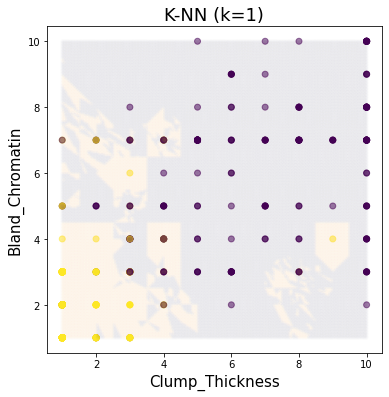

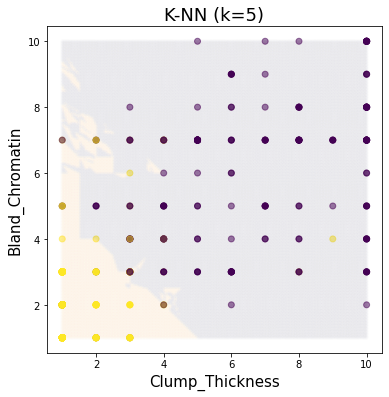

In [ ]:
#This code can be used to produce decision boundaries

x0v = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 200)
x1v = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in [1, 5]:
  model = KNN(k, euclidean)

  y_train_prob = np.zeros((y_train.shape[0], 200))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_train[:,[1,6]], y_train).predict(x_all, 1)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(x_train[:,1], x_train[:,6], c=y_train_prob[:,0], marker='o', alpha=0.5)
  ax.scatter(x_all[:,0], x_all[:,1], c=y_pred_all[:,0], marker='.', alpha=0.01)
  ax.set_ylabel('Bland_Chromatin', fontsize=15)
  ax.set_xlabel('Clump_Thickness', fontsize=15)
  ax.set_title(f"K-NN (k={k})", fontsize=18)
  #ax.legend()
  plt.show()